<a href="https://colab.research.google.com/github/giangkarry/Woodblock_image_super_resolution/blob/main/Interpolation%20method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [2]:
import os
from pathlib import Path
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import numpy as np

class HNDataset(Dataset):
  """
  class HNDataset được dùng để tải các cặp hình ảnh có độ phân giải thấp và cao.
  
  Args:
    data_root (str): Thư mục gốc của bộ dữ liệu.

  Attibutes:
    data_root (str): Thư mục gốc của bộ dữ liệu.
    low_dir (str): Thư mục chứa ảnh có độ phân giải thấp.
    high_dir (str): Thư mục chứa ảnh có độ phân giải cao.
    low_image_list (list): Danh sách các đường dẫn đến các ảnh LR.
    high_image_list (list): Danh sách các đường dẫn đến các ảnh HR.
    lr_transform (torchvision.transforms.Compose): Chuỗi các phép biến đổi ảnh được áp dụng cho ảnh LR.
    hr_transform (torchvision.transform.Compose): Chuỗi các phép biến đổi ảnh được áp dụng cho ảnh HR.

  Methods:
    __len__(self): Trả về kích thước bộ dữ liệu ảnh LR (bằng với kích thước ảnh HR)
    __getitem__(idx): Load, xử lý ảnh LR, HR tại chỉ số idex và trả về chúng
  """
  def __init__(self, data_root):
    super(HNDataset, self).__init__()
    self.data_root = data_root
    self.low_dir = os.path.join(self.data_root, "low")
    self.high_dir = os.path.join(self.data_root, "high")
    self.low_image_list = list(Path(self.low_dir). glob("*.png"))
    self.high_image_list = list(Path(self.high_dir). glob("*.png"))
    self.lr_transform = Compose([
            ToTensor(), #phạm vi [0,1]
        ])
    self.hr_transform = Compose([
            ToTensor(), 
        ])

  def __len__(self):
    return len(self.low_image_list)

  def __getitem__(self, idx):
    low_img = Image.open(self.low_image_list[idx])
    high_img = Image.open(self.high_image_list[idx])
    tensor_low = self.lr_transform(low_img)
    tensor_high = self.hr_transform(high_img)
    return tensor_low, tensor_high

In [3]:
path = '/content/drive/MyDrive/Data/6TResize/SRDataset/'
test_set = HNDataset(path + 'test')

# Các chỉ số đánh giá

In [4]:
import torch
import torch.nn.functional as F
from math import exp
class SSIM:
  '''
  Lớp SSIM tính toán chỉ số SSIM giữa hai hình ảnh

  '''
  def __init__(self, window_size=11, sigma=1.5, size_average=True):
    '''
    Khởi tạo lớp SSIM với các tham số đầu vào:
      window_size(int): kích thước cửa sổ để tính toán chỉ số SSIM. Mặc định là 11
      sigma(float): giá trị độ lệch chuẩn của bộ lọc Gaussian để tạo ra cửa sổ. Mặc định là 1.5
      size_average(boolean): trả về giá trị SSIM trung bình cho toàn bộ batch (True) hay trả về trung bình cho mỗi hình ảnh trong batch(False). Mặc định là True

    '''
    self.window_size = window_size
    self.size_average = size_average
    self.sigma = sigma

  def gaussian(self):
    '''
    Return:
      gauss(torch.Tensor): bộ lọc Gaussian 1D với số phần tử bằng window_size
    '''
    gauss = torch.Tensor([exp(-(x-self.window_size//2)**2/float(2*self.sigma**2))for x in range(self.window_size)]) 
    return gauss/gauss.sum() # (window_size)
  
  def create_window(self, channels, groups):
    '''
    Tạo cửa sổ 2D từ bộ lọc Gaussian 1D

    Args:
      channels (int): số kênh của hình ảnh đầu vào
      groups (int): số lượng groups được sử dụng trong phép toán convolution

    Return:
      window (torch.Tensor): cửa sổ 2D với kích thước window_size x window_size
    '''
    _1d_window = self.gaussian().unsqueeze(1) #(window_size, 1)
    _2d_window = torch.mm(_1d_window, _1d_window.t()).unsqueeze(0).unsqueeze(0) # (1,1,window_size, window_size)
    window = _2d_window.expand(channels, channels//groups, self.window_size, self.window_size).contiguous()
    return window # (channel, channel/group, window_size, window_size): (3, 1, 11,11)

  def ssim(self, img1, img2):
    '''
    Tính chỉ số SSIM giữa hai hình ảnh đầu vào

    Args:
      img1(torch.Tensor): ảnh thứ nhất, kích thước (batch_size, channel, height, width)
      img2(torch.Tensor): ảnhthứ hai, kích thước (batch_size, channel, height, width)

    Returns:
      ssim(torch.Tensor): giá trị ssim giữa hai hình ảnh. 
        Nếu 'size_average' là True, trả về một vô hướng đại diện cho trung bình SSIM trên toàn bộ batch.
        Nếu 'size_average' là False, trả về một tensor đại diện cho SSIM cho mỗi ảnh trong batch

    '''
    channel = img1.shape[1] # <=>img1.size()[1] hoặc (_, channel,_,_) = img1.size(): int
    window = self.create_window(channel, channel) # (3,1,11,11)
    if img1.is_cuda:
      window = window.cuda(img1.get_device())
    mu1 = F.conv2d(img1, window, padding=(self.window_size-1)//2, groups=channel) # (N,c,h,w)
    mu2 = F.conv2d(img2, window, padding=(self.window_size-1)//2, groups=channel) #(N,c,h,w)

    mu1_sq = mu1**2 #(N,c,h,w)
    mu2_sq = mu2**2 #(N,c,h,w)
    mu1_mu2 = mu1*mu2 #(N,c,h,w)

    #sigma^2 = E(x^2)-(E(x))^2
    #sigma_xy = E(xy)-E(x)E(y)
    sigma1_sq = F.conv2d(img1**2, window, padding=(self.window_size-1)//2, groups=channel)-mu1_sq #(N,c,h,w)
    sigma2_sq = F.conv2d(img2**2, window, padding=(self.window_size-1)//2, groups=channel)-mu2_sq #(N,c,h,w)
    sigma12 = F.conv2d(img1*img2, window, padding=(self.window_size-1)//2, groups=channel)-mu1_mu2 #(N,c,h,w)

    # C1=(k1L)**2, C2=(k2L)^2 trong đó mặc định của k1=0.01, k2=0.03
    # L là dynamic range của giá trị pixel (thường 2^bit_per_pixel - 1: max-min)
    # compute coefficients
    C1 = 0.01**2
    C2 = 0.03**2
    
    ssim = ((2.0*mu1_mu2 + C1)*(2.0*sigma12 + C2))/((mu1_sq +mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2)) #(N, c, h, w)
    if self.size_average:
      return ssim.mean() 
    else:
      return ssim.mean(dim=(1,2,3))# tương tự ssim.mean(1).mean(1).mean(1) # batch_size

class PSNR:
  def __init__(self):
    pass
  def update(self, sr, hr):
    data_range = 1
    dim = tuple(range(1,hr.ndim)) #(1,2,3)
    mse_error = torch.pow((sr-hr),2).mean(dim=dim) # (batch_size)
    batch_psnr = 10.0 * torch.log10(1/(mse_error)) #(batch_size)
    return batch_psnr


# Nâng độ phân giải bằng phép nội suy

## Nội suy 1 hình ảnh

In [ ]:
from PIL import Image
class UpscaleImageInterpolation:
  def __init__(self,lr_image, hr_image=None, upscale_factor=4, device='cpu', ssim=None, psnr=None):
    self.lr_image = lr_image
    self.hr_image = hr_image
    self.upscale_factor = upscale_factor
    self.width, self.height = lr_image.size
    self.nni_image = None
    self.bilinear_image = None
    self.bicubic_image = None
    self.device=device
    self.ssim=ssim
    self.psnr = psnr
    self.result = {'ssim':0, 'psnr':0}

  def nearest_neighbor_interpolation(self):
    self.nni_image = self.lr_image.resize((self.width*self.upscale_factor, self.height*self.upscale_factor), Image.NEAREST)
    return self.nni_image
  def bilinear_interpolation(self):
    self.bilinear_image = self.lr_image.resize((self.width*self.upscale_factor, self.height*self.upscale_factor), Image.BILINEAR)
    return self.bilinear_image
  def bicubic_interpolation(self):
    self.bicubic_image = self.lr_image.resize((self.width*self.upscale_factor, self.height*self.upscale_factor), Image.BICUBIC)
    return self.bicubic_image
  
  def get_images(self):
    self.nni_image = self.nearest_neighbor_interpolation()
    self.bilinear_image = self.bilinear_interpolation()
    self.bicubic_image = self.bicubic_interpolation()
    return self.nni_image, self.bilinear_image, self.bicubic_image
  
  def bicubic_metrics(self):
    with torch.no_grad():
      self.bicubic_image = self.bicubic_interpolation()
      bicubic_image = ToTensor()(self.bicubic_image).unsqueeze(0).to(self.device) #(1,3,h,w)
      hr_image = ToTensor()(self.hr_image).unsqueeze(0).to(self.device)
      self.result['ssim'] = self.ssim.ssim(bicubic_image,hr_image).item()
      self.result['psnr'] = self.psnr.update(bicubic_image,hr_image).item()
    return self.result
  

{'ssim': 0.8358495831489563, 'psnr': 26.004770278930664}


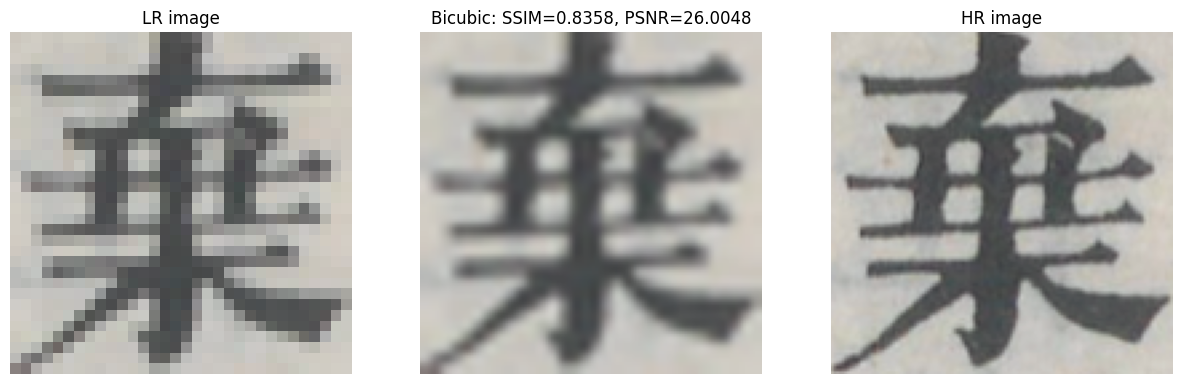

In [ ]:
import matplotlib.pyplot as plt

lr_path='/content/drive/MyDrive/Data/6TResize/SRDataset/test/low/1048.png'
hr_path = '/content/drive/MyDrive/Data/6TResize/SRDataset/test/high/1048.png'
lr_image = Image.open(lr_path)
hr_image = Image.open(hr_path)

psnr = PSNR()
ssim = SSIM(size_average=False)
interpolation = UpscaleImageInterpolation(lr_image, hr_image, device=device, ssim=ssim, psnr=psnr)
nni_image, bilinear_image, bicubic_image = interpolation.get_images()
result = interpolation.bicubic_metrics()
print(result)

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('LR image', fontsize=12)
plt.imshow(lr_image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('Bicubic: SSIM='+ str(round(result['ssim'],4)) + ', PSNR=' + str(round(result['psnr'],4)), fontsize=12)
plt.imshow(bicubic_image)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('HR image', fontsize=12)
plt.imshow(hr_image)
# plt.xticks([0, 128])
# plt.yticks([0, 128])
# Ẩn các trục x và 
plt.axis('off')
plt.show()


# nni_image.save('/content/drive/MyDrive/Image/nni_image_1031.png')
# bilinear_image.save('/content/drive/MyDrive/Image/bilinear_image_1031.png')
bicubic_image.save('/content/drive/MyDrive/Image/bicubic_image_1048.png')

## Tính chỉ số SSIM, PSNR của tập test

In [5]:
# class BicubicTest:
#   def __init__(self, low_path,high_path,upscale_factor, psnr, ssim):
#     self.low_path = low_path
#     self.high_path = high_path
#     # self.device = device
#     self.upscale_factor = upscale_factor
#     self.psnr = psnr
#     self.ssim = ssim
#     self.results = {'ssim':0, 'psnr':0, 'size':0}
#   def test(self):
#     for file_name in os.listdir(self.low_path):
#       lr_img = Image.open(os.path.join(self.low_path, file_name))
#       width, height = lr_img.size
#       hr_img = Image.open(os.path.join(self.high_path, file_name))
#       bicubic = lr_img.resize((width*self.upscale_factor, height*self.upscale_factor), Image.BICUBIC)

#       bicubic = ToTensor()(bicubic).unsqueeze(0)#.to(self.device) #(1,3,h,w)
#       hr_img = ToTensor()(hr_img).unsqueeze(0)#.to(self.device)
#       self.results['ssim'] += self.ssim.ssim(bicubic,hr_img).item()
#       self.results['psnr'] +=  self.psnr.update(bicubic,hr_img).item()
#       self.results['size'] += 1
#     self.results['psnr'] = self.results['psnr']/self.results['size']
#     self.results['ssim'] = self.results['ssim']/self.results['size']
#     return self.results

In [7]:
# low_path='/content/drive/MyDrive/Data/6TResize/SRDataset/test/low'
# high_path = '/content/drive/MyDrive/Data/6TResize/SRDataset/test/high'

# upscale_factor = 4
# psnr = PSNR()
# ssim = SSIM(size_average=False)
# test_bicubic = BicubicTest(low_path, high_path, upscale_factor, psnr, ssim)
# results = test_bicubic.test()
# print(results)

{'ssim': 0.8536155379811923, 'psnr': 27.64665140469869, 'size': 600}


In [8]:
from torchvision.transforms.transforms import ToPILImage
class BicubicInterpolationTest:
  def __init__(self, test_loader, upscale_factor, psnr, ssim):
    self.test_loader = test_loader
    self.upscale_factor=upscale_factor
    self.psnr = psnr
    self.ssim = ssim
    self.results = {'psnr':0, 'ssim':0}
  def test(self):
    # with torch.no_grad():
    for lr, hr in self.test_loader:
      _,_,height, width = lr.size()
      lr = ToPILImage()(lr.squeeze().cpu())
      bicubic = lr.resize((width*self.upscale_factor, height*self.upscale_factor), Image.BICUBIC) # Bicubic
      bicubic = ToTensor()(bicubic).unsqueeze(0)
      #Tính các chỉ số mse, ssim, psnr
      self.results['ssim'] += torch.sum(self.ssim.ssim(bicubic, hr)).item()
      self.results['psnr'] += torch.sum(self.psnr.update(bicubic,hr)).item()
    # Tính trung bình các chỉ số cho toàn bộ dữ liệu
    self.results['psnr'] = self.results['psnr']/len(self.test_loader.dataset)
    self.results['ssim'] = self.results['ssim']/len(self.test_loader.dataset)
    return self.results

In [13]:
from torch.utils.data import DataLoader
test_loader_bicubic = DataLoader(dataset=test_set, num_workers=2, batch_size=1, shuffle=False)

psnr = PSNR()
ssim = SSIM(size_average=False)
bicubic_test = BicubicInterpolationTest(test_loader_bicubic, upscale_factor,psnr, ssim)
results = bicubic_test.test()
print(results)

{'psnr': 27.64665140469869, 'ssim': 0.8536155379811923}
